In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import rpy2.rinterface_lib.callbacks
import logging
 
from rpy2.robjects import pandas2ri
import anndata2ri
import sys
sys.path.insert(0, "/home/sturm/projects/2020/scanpy/")
import scanpy as sc
import scanpy.external as sce
from sctransform import sctransform

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
%load_ext rpy2.ipython

In [3]:
%%R

# Load all the R libraries we will be using in the notebook
library(scran)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [4]:
adata = sc.read_h5ad("/tmp/adata.h5ad")

In [5]:
# adata = sc.datasets.pbmc3k()

In [6]:
adata_raw = adata.copy()
sc.pp.log1p(adata_raw)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

### CPM normalization

In [8]:
adata_cpm = adata.copy()
adata_cpm.raw = adata_raw
sc.pp.normalize_per_cell(adata_cpm, counts_per_cell_after=1e6)
sc.pp.log1p(adata_cpm)
sc.pp.highly_variable_genes(adata_cpm, flavor="cell_ranger", n_top_genes=4000)
sc.pp.pca(adata_cpm)
sc.pp.neighbors(adata_cpm)
sc.tl.leiden(adata_cpm)
sc.tl.umap(adata_cpm)

### Scran normalization

In [9]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

In [10]:
adata_scran = adata.copy()

In [11]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_scran.X.T.toarray()

In [12]:
pandas2ri.activate()
anndata2ri.activate()

In [13]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [14]:
pandas2ri.deactivate()
anndata2ri.deactivate()

/home/sturm/.conda/envs/single-cell-analysis-nf-norm/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

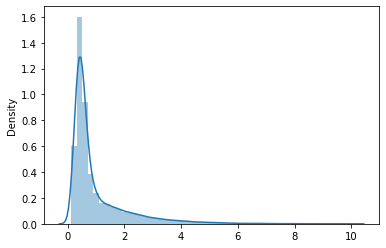

In [15]:
sns.distplot(size_factors)

In [16]:
adata_scran.obs['size_factors'] = size_factors

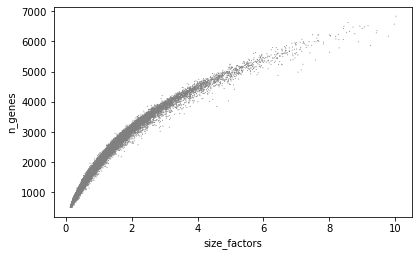

In [17]:
sc.pl.scatter(adata_scran, 'size_factors', 'n_genes')

In [18]:
adata_scran.layers["counts"] = adata_scran.X.copy()

In [19]:
sparse_size_factors = sp.sparse.diags(1/adata_scran.obs['size_factors'])

In [20]:
adata_scran.X = sparse_size_factors @ adata_scran.X

In [21]:
sc.pp.log1p(adata_scran)

In [22]:
adata_scran.raw = adata_scran

In [23]:
sc.pp.highly_variable_genes(adata_scran, flavor="cell_ranger", n_top_genes=4000)

In [24]:
sc.pp.pca(adata_scran, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_scran)
sc.tl.umap(adata_scran)

In [25]:
sc.tl.leiden(adata_scran)

### sctransform normalization

In [26]:
adata_sct = adata.copy()
adata_sct.raw = adata_raw

In [27]:
# adata_sct.X = adata_sct.X.toarray()

In [28]:
sctransform(adata_sct, n_top_genes=4000)

R[write to console]: Calculating cell attributes for input UMI matrix

R[write to console]: Variance stabilizing transformation of count matrix of size 12604 by 29934

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 29934 cells



  |======================================================================| 100%


R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Skip calculation of full residual matrix

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 14.85336 mins

R[write to console]: Calculating variance for residuals of type pearson for 12604 genes



  |======================================================================| 100%


R[write to console]: Computing corrected UMI count matrix



  |======================================================================| 100%


In [29]:
# sc.pp.highly_variable_genes(adata_sct, flavor="cell_ranger", n_top_genes=4000)

In [30]:
sc.pp.log1p(adata_sct)

In [31]:
sc.pp.pca(adata_sct, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_sct)
sc.tl.umap(adata_sct)

### scran + sctransform

In [32]:
adata_scran_sct = adata.copy()

In [33]:
adata_scran_sct.X = sparse_size_factors @ adata_scran_sct.X

In [34]:
sctransform(adata_scran_sct, n_top_genes=4000)

R[write to console]: Calculating cell attributes for input UMI matrix

R[write to console]: Variance stabilizing transformation of count matrix of size 12604 by 29934

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 29934 cells



  |======================================================================| 100%


R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Skip calculation of full residual matrix

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.733114 hours

R[write to console]: Calculating variance for residuals of type pearson for 12604 genes



  |======================================================================| 100%


R[write to console]: Computing corrected UMI count matrix



  |======================================================================| 100%


In [35]:
sc.pp.log1p(adata_scran_sct)

In [36]:
sc.pp.pca(adata_scran_sct, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_scran_sct)
sc.tl.umap(adata_scran_sct)

### Visualize

In [37]:
markers = ["CD8A", "CD4", "FOXP3", "sample"]

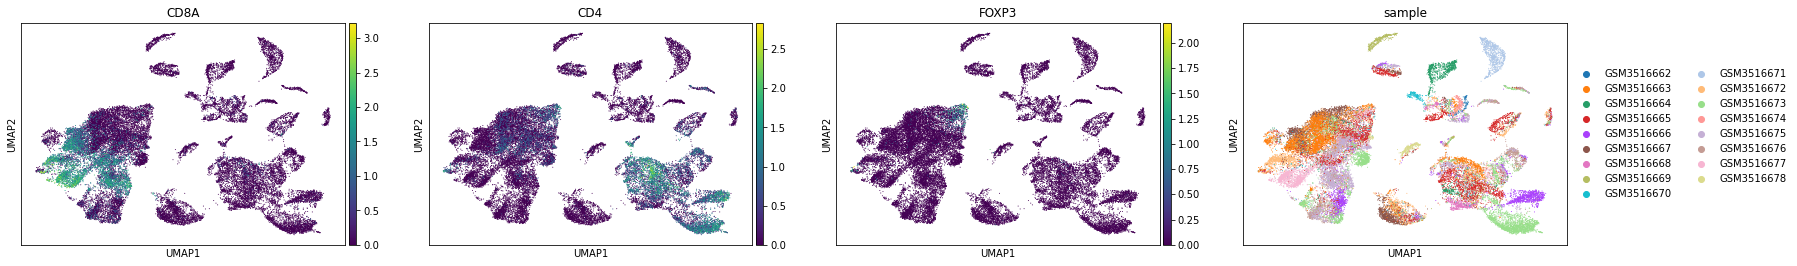

In [38]:
sc.pl.umap(adata_cpm, color=markers)

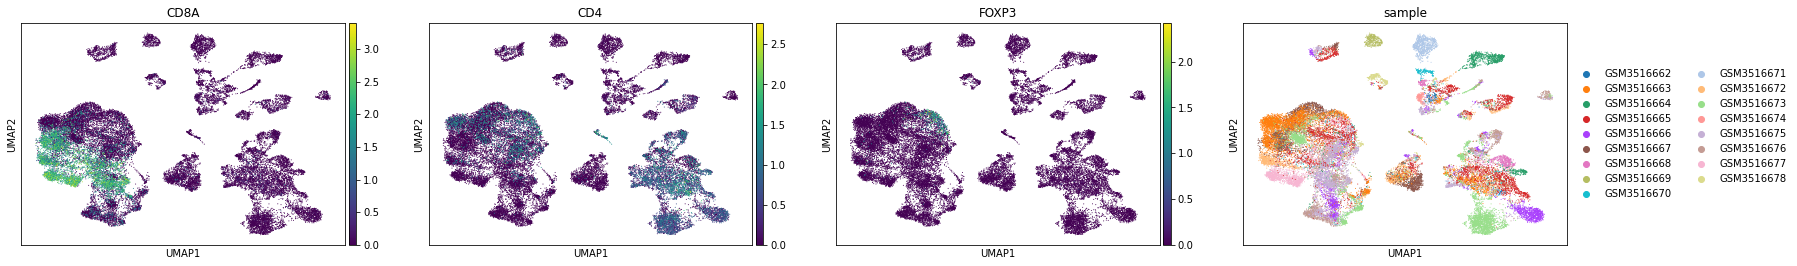

In [39]:
sc.pl.umap(adata_scran, color=markers)

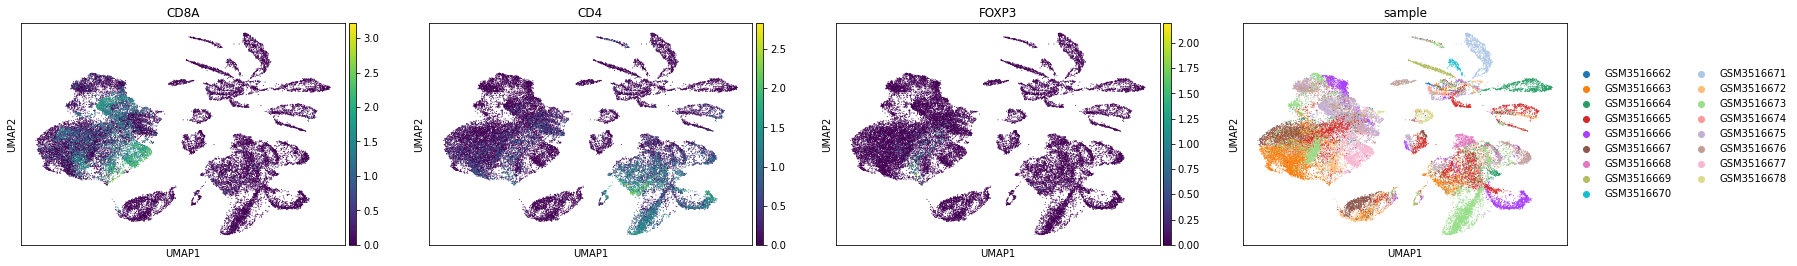

In [40]:
sc.pl.umap(adata_sct, color=markers)

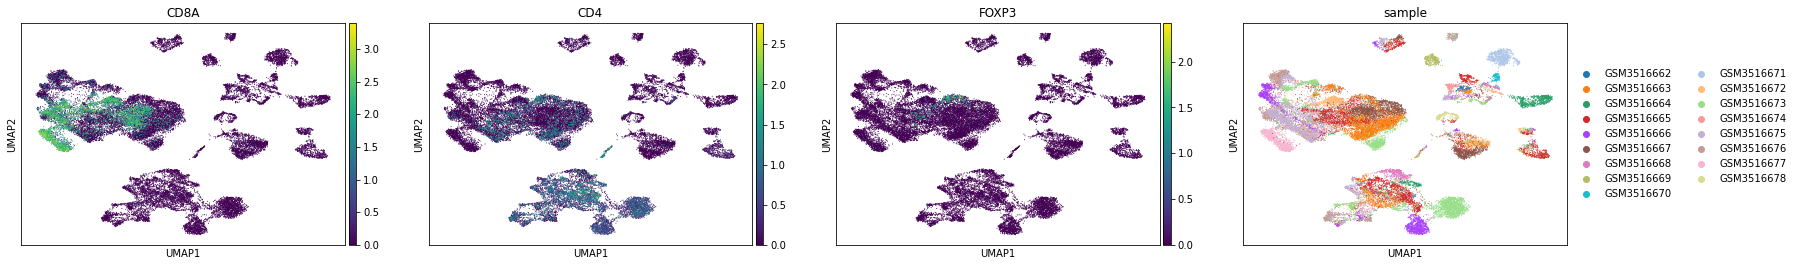

In [41]:
sc.pl.umap(adata_scran_sct, color=markers)